Neighborhoods Clustering in Toronto

Installing all the required libraries and packages

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json
from pandas.io.json import json_normalize

!conda install -c conda-forge geopy --yes
!conda install -c conda-forge beautifulsoup4 --yes #Installing BeautifulSoup
!conda install -c conda-forge lxml --yes  #Installing Parser library

from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

import requests

import matplotlib.cm as cm
import matplotlib.colors as colors
print('Libraries Installed')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    sci

Utilizing 'Beautifulsoup' to scrape the 'Wikipedia webpage' and extract the table to convert to a Dataframe, for visualization and analysis

In [2]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content, features='html')
table = soup.find_all('table')[0] 
df = pd.read_html(str(table))[0]

In [3]:
#Printing the dataset: 
print(df.shape)
df.head()

(287, 3)


,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Drop rows where boroughs values are "Not assigned": 

In [4]:
df = df[df['Borough']!='Not assigned']
df[:10]

,Postcode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Queen's Park,Not assigned
9,M9A,Downtown Toronto,Queen's Park
10,M1B,Scarborough,Rouge
11,M1B,Scarborough,Malvern
13,M3B,North York,Don Mills North


Replacing "Not assigned" Neighborhoods with 'Borough' values:

In [5]:
df['Neighborhood'] = np.where(df['Neighborhood'] == 'Not assigned', df['Borough'], df['Neighborhood'])

#Resetting the index values for the final dataframe: 
df= df.reset_index(drop=True)
df[:10]

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor
5,M7A,Queen's Park,Queen's Park
6,M9A,Downtown Toronto,Queen's Park
7,M1B,Scarborough,Rouge
8,M1B,Scarborough,Malvern
9,M3B,North York,Don Mills North


Combining neighbourhoods in same zip code into 1 data row:

In [6]:
df= df.groupby(['Postcode', 'Borough'])['Neighborhood'].apply(', '.join).reset_index()

print(df.shape)
df.head()

(103, 3)


,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


Loading the 'CSV' file for obtaining 'Latitude' and 'Longitude' values of all 'zipcodes':

In [7]:
import csv
import os
file_path = '/resources/labs/DP0701EN/Geospatial_Coordinates.csv'
print(os.getcwd())
geo_coordinates = pd.read_csv(file_path)
geo_coordinates.head()

/resources/labs/DP0701EN


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Merge the 2 tables on 'Postcode' to create latitude and longitude values for all 'Boroughs' and their respective 'Neighborhood': 

In [8]:
#Rename the 1st column of the dataframe as 'Postcode':
geo_coordinates = geo_coordinates.rename(columns ={"Postal Code": "Postcode"})

df = df.merge(geo_coordinates, on = 'Postcode')
print(df.shape)
df.head()

(103, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


Obtain the Latitude and Longitude of Toronto: 

In [9]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="foursquare_agent")

address = "Toronto, Ontario"
location = geolocator.geocode(address)

latitude = location.latitude
longitude = location.longitude

Create a visual map of Toronto and its neighbourhoods and corresponding Boroughs:

In [10]:
import folium
toronto_map = folium.Map(location = [latitude, longitude], zoom_start = 11)

folium.CircleMarker(
        [latitude, longitude],
        popup = 'Toronto', 
        radius = 8,
        color = 'red',
        fill = True, 
        fill_color = 'red',
        opacity = 1.0).add_to(toronto_map)

for lat, long, neigh, boro in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Borough']):
    label = '{}; {}'.format(neigh, boro)
    label = folium.Popup(label,parse_html = True)
    folium.CircleMarker(
        [lat, long],
        popup = label, 
        radius = 4,
        color = 'blue',
        fill = True, 
        fill_color = 'blue',
        opacity = 0.4,
        parse_html = False).add_to(toronto_map)
    
toronto_map

Filtering out neighborhoods to include 'Boroughs' of Toronto only:

In [11]:
df_1 = []
df_1 = df[df['Borough'].str.contains('Toronto')].reset_index(drop = True)
print(df_1.shape)
df_1.head()

(39, 5)


,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


Creating the URL to explore venues around 'Toronto':


In [12]:
CLIENT_ID = '4U1D1Y4NBCWGRWG0AQ4OWDDCTYA13HNM3FRZBJIA3ES5ZN5Q' #Your Foursquare ID
CLIENT_SECRET = 'FPLOCTRVGFFZ5Q4X5GFNPAOPZ4SCWPVHEG2QNDSKFZJ22QYE' #Your Foursquare Secret
VERSION = '20191229' #Foursquare API Version
RADIUS = 500
LIMIT = 100

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, RADIUS, LIMIT)

#url = 'https://api.foursquare.com/v2/venue/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID,CLIENT_SECRET,latitude,longitude,VERSION,RADIUS,LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?client_id=4U1D1Y4NBCWGRWG0AQ4OWDDCTYA13HNM3FRZBJIA3ES5ZN5Q&client_secret=FPLOCTRVGFFZ5Q4X5GFNPAOPZ4SCWPVHEG2QNDSKFZJ22QYE&ll=43.653963,-79.387207&v=20191229&radius=500&limit=100'

Caling the 'Get' method to load the json 

In [13]:
#Explore the neighborhoods in Toronto: 
json_data = requests.get(url).json()

#json_data

Extracting only the relevant items from the JSON file:

In [14]:
fin_results = json_data['response']['groups'][0]['items']
fin_results[1]

{'reasons': {'count': 0,
  'items': [{'summary': 'This spot is popular',
    'type': 'general',
    'reasonName': 'globalInteractionReason'}]},
 'venue': {'id': '4ae7b27df964a52068ad21e3',
  'name': 'Japango',
  'location': {'address': '122 Elizabeth St.',
   'crossStreet': 'at Dundas St. W',
   'lat': 43.65526771691681,
   'lng': -79.38516506734886,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.65526771691681,
     'lng': -79.38516506734886}],
   'distance': 219,
   'postalCode': 'M5G 1P5',
   'cc': 'CA',
   'city': 'Toronto',
   'state': 'ON',
   'country': 'Canada',
   'formattedAddress': ['122 Elizabeth St. (at Dundas St. W)',
    'Toronto ON M5G 1P5',
    'Canada']},
  'categories': [{'id': '4bf58dd8d48988d1d2941735',
    'name': 'Sushi Restaurant',
    'pluralName': 'Sushi Restaurants',
    'shortName': 'Sushi',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/sushi_',
     'suffix': '.png'},
    'primary': True}],
  'photos': {'count': 0, 'groups':

Create a function to extract categories of the venue:

In [15]:
#Explore the venues nearby the neighborhood:
def get_category_name(row):
    try:
        category_list = row['categories']
    except: 
        category_list = row['venue.categories']
        
    if len(category_list) == 0:
        return None
    else: 
        return category_list[0]['name']

Converting the JSON data into a Dataframe and finding the shape of the Dataframe:

In [16]:
results_df = json_normalize(fin_results)

results_df[:10]
results_df.shape

(78, 22)

Cleaning the Dataframe to include only relevant information:

In [17]:
results_df.head()

#Create a DataFrame of the filtered columns: 
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']

filtered_df = results_df.loc[:,filtered_columns]

#Extract the category "name" from the "venue.categories" column: 
filtered_df['venue.categories'] = filtered_df.apply(get_category_name, axis = 1)

#Filter the column names: 
filtered_df.columns = [col.split('.')[-1] for col in filtered_df.columns]

filtered_df.head()

,name,categories,lat,lng
0,Downtown Toronto,Neighborhood,43.653232,-79.385296
1,Japango,Sushi Restaurant,43.655268,-79.385165
2,Cafe Plenty,Café,43.654571,-79.389450
3,Rolltation,Japanese Restaurant,43.654918,-79.387424
4,Sansotei Ramen 三草亭,Ramen Restaurant,43.655157,-79.386501


Testing the to see if there any neighborhoods with 0 venues around:

In [18]:
#lat = df_Toronto['Latitude'][1], long = df_Toronto['Longitude'][1]
lat = 43.99526
long = -79.341923
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, RADIUS, LIMIT)

results = requests.get(url).json()["response"]['groups'][0]['items']

results
len(results)

#df_Toronto.head() 

0

Creating a function to repeat the above for every neighborhood in the borough of "Toronto": 

In [19]:
def get_venue_names(neighborhood_name, latitude, longitude, RADIUS=500):
    
    venues_list=[]
    for name, lat, lng in zip(neighborhood_name, latitude, longitude):
        print(name)
            
        #create the API request URL:
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
        CLIENT_ID, CLIENT_SECRET, lat, long, VERSION, RADIUS, LIMIT)
            
        #Make the GET request:
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Return only relevant information for each nearby venue:
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['categories'][0]['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng']) for v in results if len(results)!= 0])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood name', 
                  'Neighborhood latitude', 
                  'Neighborhood longitude', 
                  'Venue name',
                  'Venue category',
                  'Venue latitude', 
                  'Venue longitude']
    
    return(nearby_venues)

Calling the 'get_venue_names' function to list all the venues around ALL neighborhoods in boroughs of 'Toronto':

In [20]:
df_Toronto = df[df['Borough'].str.contains('Toronto')].reset_index(drop = True)

#Get nearby venues for all neighborhoods in 'Toronto':
toronto_venues = get_venue_names(neighborhood_name = df_Toronto['Neighborhood'], latitude = df_Toronto['Latitude'], 
                longitude = df_Toronto['Longitude'], RADIUS=500)

toronto_venues.shape

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction Sout

(739, 7)

Grouping the venues for each neighborhood:

In [21]:
toronto_venues.groupby('Neighborhood name').count().reset_index(drop=False)

,Neighborhood name,Neighborhood latitude,Neighborhood longitude,Venue name,Venue category,Venue latitude,Venue longitude
0,"Adelaide, King, Richmond",4,4,4,4,4,4
1,Berczy Park,2,2,2,2,2,2
2,"Brockton, Exhibition Place, Parkdale Village",4,4,4,4,4,4
3,Business Reply Mail Processing Centre 969 Eastern,43,43,43,43,43,43
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",1,1,1,1,1,1
5,"Cabbagetown, St. James Town",34,34,34,34,34,34
6,Central Bay Street,39,39,39,39,39,39
7,"Chinatown, Grange Park, Kensington Market",9,9,9,9,9,9
8,Christie,28,28,28,28,28,28
9,Church and Wellesley,32,32,32,32,32,32


Counting number of unique venue categories: 

In [22]:
uniq_categories = len(toronto_venues['Venue category'].unique())

print('There are {} unique venue categories found in the borough of Toronto'.format(uniq_categories))

There are 107 unique venue categories found in the borough of Toronto


Analysing each of the neighborhoods in Toronto AND 'One-Hot-Encoding' all venue categories in 'Toronto', for each 'Neighborhood':

In [23]:
toronto_one_hot = pd.get_dummies(toronto_venues['Venue category'], prefix="", prefix_sep="")

toronto_one_hot['Neighborhood'] = toronto_venues['Neighborhood name']

#re-arranging the columns to have 'Neighborhood' as the 1st column:
fixed_columns = ['Neighborhood'] + list(toronto_one_hot.columns[:])

toronto_one_hot = toronto_one_hot[fixed_columns]

#Removing duplicate columns from the dataframe: 
toronto_one_hot = toronto_one_hot.loc[:,~toronto_one_hot.columns.duplicated()]

toronto_one_hot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Line,Business Service,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food Court,Frame Store,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hostel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Latin American Restaurant,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Music Store,Nail Salon,Office,Park,Performing Arts Venue,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Soccer Field,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,The Beaches,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Groupby using the 'Neighborhood' column find the mean for each of the 'venue categories' for each 'Neighborhood':

In [24]:
toronto_grouped_neighborhood = toronto_one_hot.groupby('Neighborhood').mean().reset_index()

toronto_grouped_neighborhood.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Asian Restaurant,Athletics & Sports,BBQ Joint,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Store,Bike Shop,Bistro,Bookstore,Breakfast Spot,Brewery,Burger Joint,Bus Line,Business Service,Café,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food Court,Frame Store,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gas Station,Gastropub,Gay Bar,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hostel,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Lake,Latin American Restaurant,Lounge,Mexican Restaurant,Middle Eastern Restaurant,Movie Theater,Music Store,Nail Salon,Office,Park,Performing Arts Venue,Pet Store,Pharmacy,Pide Place,Pizza Place,Playground,Polish Restaurant,Portuguese Restaurant,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Science Museum,Seafood Restaurant,Soccer Field,Spa,Sporting Goods Shop,Sports Club,Stationery Store,Supermarket,Sushi Restaurant,Taco Place,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.25,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.25,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.25,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,Berczy Park,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.50,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.25,0.0,0.0,0.25,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.046512,0.0,0.0,0.0,0.046512,0.023256,0.046512,0.00,0.00,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.00,0.069767,0.0,0.023256,0.0,0.023256,0.023256,0.0,0.069767,0.023256,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.023256,0.0,0.0,0.0,0.023256,0.0,0.0,0.023256,0.0,0.046512,0.023256,0.0,0.0,0.0,0.00,0.023256,0.0,0.0,0.023256,0.0,0.046512,0.0,0.0,0.023256,0.023256,0.0,0.023256,0.0,0.0,0.0,0.00,0.023256,0.0,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.046512,0.0,0.023256,0.00,0.0,0.0,0.00,0.023256,0.0,0.0,0.0,0.023256,0.023256,0.023256,0.0,0.0,0.0,0.0,0.0,0.0,0.023256


Exploring the shape of the 'aggregated' and grouped Neighborhoods of Toronto:

In [25]:
toronto_grouped_neighborhood.shape

(38, 107)

Creating a function to return the 'n' most common venues for each of the neighborhoods in Toronto:

In [26]:
def find_most_common_venues(row, num_top_ven):
    venue_categories = row.iloc[1:]
    venue_categories_sorted = venue_categories.sort_values(ascending=False)
    
    return venue_categories_sorted.index.values[0:num_top_ven]    
    

Calling the above function (of common venues in each 'Neighborhood') and storing it a newly created Dataframe called "toronto_sorted_neigh":

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#Create the 11 columns of the Dataframe: 
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1,indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
#Create the Pandas DataFrame: 
toronto_sorted_neigh = pd.DataFrame(columns = columns)
toronto_sorted_neigh['Neighborhood'] = toronto_grouped_neighborhood['Neighborhood']

#Sort the 10 most common venues per neighborhood in descending order, in the created Dataframe:
for i in np.arange(toronto_grouped_neighborhood.shape[0]):
    toronto_sorted_neigh.iloc[i,1:] = find_most_common_venues(toronto_grouped_neighborhood.iloc[i,:], num_top_venues)
    
print(toronto_sorted_neigh.shape)
toronto_sorted_neigh.head()

(38, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Gym,Office,Baseball Field,Business Service,Yoga Studio,Donut Shop,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio
1,Berczy Park,Playground,Soccer Field,Yoga Studio,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio
2,"Brockton, Exhibition Place, Parkdale Village",Sports Club,Beach,Soccer Field,Dog Run,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio
3,Business Reply Mail Processing Centre 969 Eastern,Café,Coffee Shop,American Restaurant,Bakery,Bar,Italian Restaurant,Sandwich Place,Gastropub,Yoga Studio,Furniture / Home Store
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Lake,Yoga Studio,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner


Determinig optimal number of clusters using the "WSS" and "Silhouette" methods and plotting the respective results: 

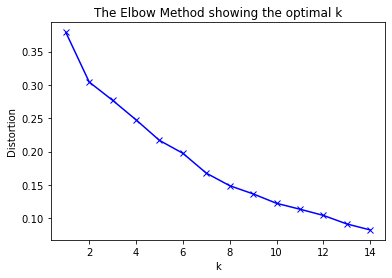

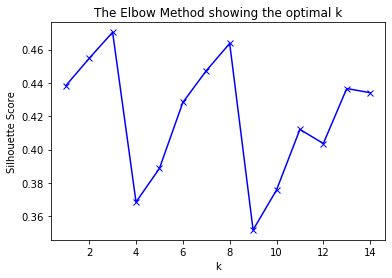

In [30]:
#Determinig optimal number of clusters using the WSS method: 
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# create new plot and data
plt.plot()
X = toronto_grouped_clustering# np.array(list(zip(x1, x2))).reshape(len(x1), 2)
colors = ['b', 'g', 'r']
markers = ['o', 'v', 's']

# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(toronto_grouped_clustering)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(np.sum(np.min(cdist(toronto_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / toronto_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

###########################################################################################################################################
#Determing Optimal number of clusters using the Silhouette method:
from sklearn.metrics import silhouette_score

sil = []
kmax = 15

# dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('The Elbow Method showing the optimal k')
plt.show()

1. Using a cluster size of 'n', per the results from the above 2 graphs/methods:
2. Calling the "KMeans" clustering algorithm to fit the data in the model and displaying the resulting labels: 

In [34]:
#Implemneting the 'K-Means Clustering' algorithm on the Toronto dataset:
from sklearn.cluster import KMeans
k_cluster = 8

toronto_grouped_clustering = toronto_grouped_neighborhood.drop(columns = ['Neighborhood'], axis = 1)

KCluster = KMeans(n_clusters = k_cluster, random_state = 0).fit(toronto_grouped_clustering)

KCluster.labels_[:]

array([3, 4, 6, 0, 2, 0, 0, 3, 0, 0, 1, 0, 5, 0, 7, 0, 1, 0, 0, 3, 6, 0,
       0, 1, 0, 5, 1, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0], dtype=int32)

Merging the dataframes to label each of the neighborhoods into their respective clusters:

In [36]:
#Merge the cluster labels to the Toronto data set:
#toronto_sorted_neigh = toronto_sorted_neigh.drop('Clusters', axis=1)
toronto_sorted_neigh.insert(0,'Clusters', KCluster.labels_)
merged_toronto_venues = df_Toronto

#print(merged_toronto_venues[-5:])
merged_toronto_venues = merged_toronto_venues.rename(columns = {'Neighborhood name':'Neighborhood'})

merged_toronto_venues = merged_toronto_venues.merge(toronto_sorted_neigh, on='Neighborhood')
print(merged_toronto_venues.shape)
merged_toronto_venues.head()        

(38, 16)


,Postcode,Borough,Neighborhood,Latitude,Longitude,Clusters,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Greek Restaurant,Toy / Game Store,Sushi Restaurant,Pizza Place,Grocery Store,Café,Diner,Pharmacy,Breakfast Spot
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Coffee Shop,Greek Restaurant,Pizza Place,Café,Furniture / Home Store,Bookstore,Grocery Store,Sushi Restaurant,Portuguese Restaurant,Breakfast Spot
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Coffee Shop,Café,Caribbean Restaurant,Fast Food Restaurant,Sandwich Place,French Restaurant,Mexican Restaurant,Movie Theater,Cocktail Bar,Clothing Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Bar,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Gastropub,Wine Bar,Electronics Store,Fish Market
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Asian Restaurant,Sporting Goods Shop,Beer Store,Clothing Store,Chinese Restaurant,Dim Sum Restaurant,Discount Store,Restaurant,Japanese Restaurant,Italian Restaurant


Creating a map to visualize the 'Clusters' of neighborhoods in Toronto which are similar one another based on types of venues located in each of the neighborhoods:

In [37]:
#Create map
import matplotlib
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters:
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [matplotlib.colors.to_hex(i) for i in colors_array]

#Add markers to the map:
markers_colors = []
for lat, lon, poi, cluster in zip(merged_toronto_venues['Latitude'], merged_toronto_venues['Longitude'], merged_toronto_venues['Neighborhood'], merged_toronto_venues['Clusters']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Analyzing the 8 different clustered neighborhoods:

1) "Cafetaria Neighborhood", Cafe's, bars and eastern european restaurants found predominantly

In [39]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 0, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,Coffee Shop,Greek Restaurant,Toy / Game Store,Sushi Restaurant,Pizza Place,Grocery Store,Café,Diner,Pharmacy,Breakfast Spot
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,Coffee Shop,Greek Restaurant,Pizza Place,Café,Furniture / Home Store,Bookstore,Grocery Store,Sushi Restaurant,Portuguese Restaurant,Breakfast Spot
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,Coffee Shop,Café,Caribbean Restaurant,Fast Food Restaurant,Sandwich Place,French Restaurant,Mexican Restaurant,Movie Theater,Cocktail Bar,Clothing Store
3,M4M,East Toronto,Studio District,43.659526,-79.340923,Café,Bar,Coffee Shop,American Restaurant,Bakery,Italian Restaurant,Gastropub,Wine Bar,Electronics Store,Fish Market
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,Asian Restaurant,Sporting Goods Shop,Beer Store,Clothing Store,Chinese Restaurant,Dim Sum Restaurant,Discount Store,Restaurant,Japanese Restaurant,Italian Restaurant
7,M4S,Central Toronto,Davisville,43.704324,-79.388790,Afghan Restaurant,Turkish Restaurant,Burger Joint,Supermarket,Pharmacy,Fried Chicken Joint,Pizza Place,Bus Line,Restaurant,Sandwich Place
8,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160,Breakfast Spot,Gourmet Shop,Performing Arts Venue,Cheese Shop,Indian Restaurant,Fish & Chips Shop,Yoga Studio,Convenience Store,Coworking Space,Cuban Restaurant
9,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049,Greek Restaurant,Pet Store,Bank,Fast Food Restaurant,Café,Flower Shop,Spa,Frame Store,Chinese Restaurant,Discount Store
10,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,Coffee Shop,Greek Restaurant,Pizza Place,Café,Furniture / Home Store,Bookstore,Grocery Store,Sushi Restaurant,Portuguese Restaurant,Breakfast Spot
11,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,Coffee Shop,French Restaurant,Vietnamese Restaurant,Café,Fast Food Restaurant,Caribbean Restaurant,Sandwich Place,Clothing Store,Polish Restaurant,Pizza Place


2) "Business-center Neighborhood", Commercial offices, business district and commercial stores found predominantly

In [40]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 1, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,M5L,Downtown Toronto,"Commerce Court, Victoria Hotel",43.648198,-79.379817,Business Service,Baseball Field,Yoga Studio,Electronics Store,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner
28,M5X,Downtown Toronto,"First Canadian Place, Underground city",43.648429,-79.382280,Business Service,Baseball Field,Yoga Studio,Electronics Store,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner
31,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,Business Service,Baseball Field,Yoga Studio,Electronics Store,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner
34,M6R,West Toronto,"Parkdale, Roncesvalles",43.648960,-79.456325,Business Service,Baseball Field,Yoga Studio,Electronics Store,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner


3) "Lakeside Neighborhood", Lakeside view and commercial stores offices found predominanty

In [41]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 2, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,M5V,Downtown Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.628947,-79.39442,Lake,Yoga Studio,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner


4) "Gynasium Neighborhood", Gyms and baseball sports grounds found predominantly

In [42]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 3, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636,Gym,Coffee Shop,Furniture / Home Store,Coworking Space,Office,Baseball Field,Business Service,Diner,Yoga Studio,Dog Run
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Coworking Space,Gym,Office,Baseball Field,Business Service,Yoga Studio,Dog Run,Convenience Store,Cuban Restaurant
18,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,Gym,Office,Baseball Field,Business Service,Yoga Studio,Donut Shop,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio
26,M5T,Downtown Toronto,"Chinatown, Grange Park, Kensington Market",43.653206,-79.400049,Gym,Coffee Shop,Furniture / Home Store,Coworking Space,Office,Baseball Field,Business Service,Yoga Studio,Dog Run,Convenience Store
35,M6S,West Toronto,"Runnymede, Swansea",43.651571,-79.484450,Coffee Shop,Coworking Space,Gym,Office,Baseball Field,Business Service,Yoga Studio,Dog Run,Convenience Store,Cuban Restaurant


5) "Sports Ground Neighborhood", sports play grounds and restaurants found predominantly

In [43]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 4, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Playground,Soccer Field,Yoga Studio,Clothing Store,Coffee Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio


6) "Science Museums Neighborhood", Museums, Sports centers and restaurants found predominantly

In [44]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 5, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,M4P,Central Toronto,Davisville North,43.712751,-79.390197,Science Museum,Athletics & Sports,Tree,Yoga Studio,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio
6,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,Science Museum,Athletics & Sports,Movie Theater,Yoga Studio,Dog Run,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio


7) "Sports Club Neighborhood", SPorts Clubs, beaches and restaurants found predominantly

In [45]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 6, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,Sports Club,Athletics & Sports,Harbor / Marina,Beach,Dog Run,Soccer Field,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space
32,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,Sports Club,Beach,Soccer Field,Dog Run,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio


8) "Financial Services Neighborhood", business center, co-working offices and restaurants found predominantly

In [46]:
merged_toronto_venues.loc[merged_toronto_venues['Clusters'] == 7, merged_toronto_venues.columns[[0,1,2,3,4] + list(range(6, merged_toronto_venues.shape[1]))]]

,Postcode,Borough,Neighborhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,Business Service,Yoga Studio,Donut Shop,Comfort Food Restaurant,Convenience Store,Coworking Space,Cuban Restaurant,Dance Studio,Dim Sum Restaurant,Diner
